In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

from ALLCools.mcds import MCDS
from ALLCools.clustering import tsne, significant_pc_test, log_scale
from ALLCools.plot import *
import glob

In [2]:
metadata_path = 'm3C_META.csv'

mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'UniqueMappingRate'  # Name may change
final_reads_cutoff_min = 500000
final_reads_cutoff_max = 10000000
final_reads_col_name = 'UniqueAlignFinalReads'  # Name may change
mccc_cutoff = 0.05
mccc_col_name = 'mCCCFrac'  # Name may change
mch_cutoff = 0.2
mch_col_name = 'mCHFrac'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change


obs_dim = 'cell'  # observation
var_dim = 'chrom100k'  # feature

# feature cov cutoffs
min_cov = 500
max_cov = 3000

black_list_path = '/data/aging/ref/m3C/mm10-blacklist.v2.bed.gz'
black_list_fraction = 0.2
exclude_chromosome = ['chrM', 'chrY']

# load to memory or not
load = True

# HVF
mch_pattern = 'CHN'
mcg_pattern = 'CGN'
n_top_feature = 20000

# PC cutoff
pc_cutoff = 0.1

# KNN
knn = -1  # -1 means auto determine

# Leiden
resolution = 1

In [3]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 73012 cells


,InputReadPairs,InputReadPairsBP,TrimmedReadPairs,R1WithAdapters,R1QualTrimBP,R1TrimmedReadsBP,R2WithAdapters,R2QualTrimBP,R2TrimmedReadsBP,UniqueMappedReads,...,Pool,Modality,Gender,Plate,Project,Age,CEMBARegion,DissectionRegion,Region,Replicate
cell,,,,,,,,,,,,,,,,,,,,,
AMB_220405_8wk_5E_6E_1_P1-1-K15-C14,1487329,447305265,1486189,932,680438,187268457,1752,476849,199267737,1685850,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-G1,1349283,405116172,1347255,584,642505,169648152,2548,450063,180227283,1542162,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-J14,1258019,378121709,1257175,413,534210,158322880,463,400885,168497487,1444705,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-E14,1354473,407574348,1353534,534,610681,170665235,923,443759,181606301,1536116,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2
AMB_220405_8wk_5E_6E_1_P1-1-K15-I1,1474148,442861110,1472585,550,650482,185481058,1917,471454,197155767,1679515,...,pool_amb38,m3C,f,AMB_220405_8wk_5E_6E_1_P1,aging,8wk,5E+6E,CP-2+CP-3,Caudate_Putamen,rep2


In [4]:
judge = (metadata[mapping_rate_col_name] > mapping_rate_cutoff) & \
        (metadata[final_reads_col_name] > final_reads_cutoff_min) & \
        (metadata[final_reads_col_name] < final_reads_cutoff_max) & \
        (metadata[mccc_col_name] < mccc_cutoff) & \
        (metadata[mch_col_name] < mch_cutoff) & \
        (metadata[mcg_col_name] > mcg_cutoff)

metadata = metadata[judge].copy()
print(f'{metadata.shape[0]} cells passed filtering')

72666 cells passed filtering


In [5]:
mcds_path = glob.glob('../230712_m3c-mc-integration/female-mcds/*.mcds')
len(mcds_path)

29

In [6]:
# not need if mcds are full
mcds = MCDS.open(
    mcds_path, 
    use_obs = metadata.index,
    obs_dim='cell', 
    var_dim='chrom100k')
#shared_cells= list(set(metadata.index) & set(mcds.get_index('cell')))

In [7]:
total_feature = mcds.get_index(var_dim).size
mcds

<xarray.MCDS>
Dimensions:          (mc_type: 2, cell: 72666, chrom100k: 26350, count_type: 2)
Coordinates:
  * mc_type          (mc_type) <U3 'CGN' 'CHN'
  * cell             (cell) <U43 'AMB_220628_18mo_3F_4E_1_P1-1-I3-A1' ... 'AM...
  * chrom100k        (chrom100k) <U10 'chr1_0' 'chr1_1' ... 'chrX_1710'
    chrom100k_chrom  (chrom100k) <U5 dask.array<chunksize=(13175,), meta=np.ndarray>
    chrom100k_end    (chrom100k) int64 dask.array<chunksize=(26350,), meta=np.ndarray>
    chrom100k_start  (chrom100k) int64 dask.array<chunksize=(26350,), meta=np.ndarray>
  * count_type       (count_type) <U3 'mc' 'cov'
Data variables:
    chrom100k_da     (cell, chrom100k, mc_type, count_type) uint32 dask.array<chunksize=(15, 13175, 1, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom100k

In [8]:
# you can add the cell metadata into MCDS
mcds.add_cell_metadata(metadata)

Feature chrom100k mean cov across cells added in MCDS.coords['chrom100k_cov_mean'].


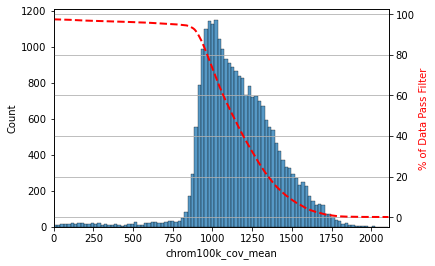

In [9]:
mcds.add_feature_cov_mean(var_dim=var_dim)

In [10]:
# filter by coverage - based on the distribution above
mcds = mcds.filter_feature_by_cov_mean(
    min_cov=min_cov,  # minimum coverage
    max_cov=max_cov  # maximum coverage
)

# remove blacklist regions
mcds = mcds.remove_black_list_region(
    black_list_path=black_list_path,
    f=black_list_fraction  # Features having overlap > f with any black list region will be removed.
)

# remove chromosomes
mcds = mcds.remove_chromosome(exclude_chromosome)

Before cov mean filter: 26350 chrom100k
 After cov mean filter: 25327 chrom100k 96.1%
1253 chrom100k features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.
0 chrom100k features in ['chrM', 'chrY'] removed.


In [11]:
mcds.add_mc_frac(
normalize_per_cell=True,  # after calculating mC frac, per cell normalize the matrix
    clip_norm_value=10  # clip outlier values above 10 to 10
)

# load only the mC fraction matrix into memory so following steps is faster
# Only load into memory when your memory size is enough to handle your dataset
if load and (mcds.get_index(obs_dim).size < 20000):
    mcds[f'{var_dim}_da_frac'].load()

In [12]:
# mch_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
#                                  mc_type=mch_pattern,
#                                  n_top_feature=n_top_feature,
#                                  plot=True)

In [13]:
# mcg_hvf = mcds.calculate_hvf_svr(var_dim=var_dim,
#                                  mc_type=mcg_pattern,
#                                  n_top_feature=n_top_feature,
#                                  plot=True)

In [14]:
mch_adata = mcds.get_adata(mc_type=mch_pattern,
                           var_dim=var_dim,
                           select_hvf=False)
mch_adata

AnnData object with n_obs × n_vars = 72666 × 24088
    obs: 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericContacts', 'NoContacts', 'MappedFragments', 'DeduppedContacts', 'ContactsDeduplicationRate', 'TotalCisContacts', 'TotalTransContacts', 'TotalMultiContacts', 'CisContactsRatio', 'TransContactsRatio', 'MultiContactsRatio', 'mCCCCov', 'mCGCov', 'mCHCov', 'mCCCmC', 'mCGmC', 'mCHmC', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Pool', 'Modality', 'Gender', 'Plate', 'Project', 'Age', 'CEMBARegion', 'DissectionRegion', 'Region

In [15]:
mcg_adata = mcds.get_adata(mc_type=mcg_pattern,
                           var_dim=var_dim,
                           select_hvf=False)
mcg_adata

AnnData object with n_obs × n_vars = 72666 × 24088
    obs: 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericContacts', 'NoContacts', 'MappedFragments', 'DeduppedContacts', 'ContactsDeduplicationRate', 'TotalCisContacts', 'TotalTransContacts', 'TotalMultiContacts', 'CisContactsRatio', 'TransContactsRatio', 'MultiContactsRatio', 'mCCCCov', 'mCGCov', 'mCHCov', 'mCCCmC', 'mCGmC', 'mCHmC', 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'Pool', 'Modality', 'Gender', 'Plate', 'Project', 'Age', 'CEMBARegion', 'DissectionRegion', 'Region

In [16]:
log_scale(mch_adata)

StandardScaler(with_mean=False)

In [17]:
log_scale(mcg_adata)

StandardScaler(with_mean=False)

Downsample PC matrix to 50000 cells to calculate significant PC components
49 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (72666, 50) to (72666, 49)
Red axis labels are used PCs


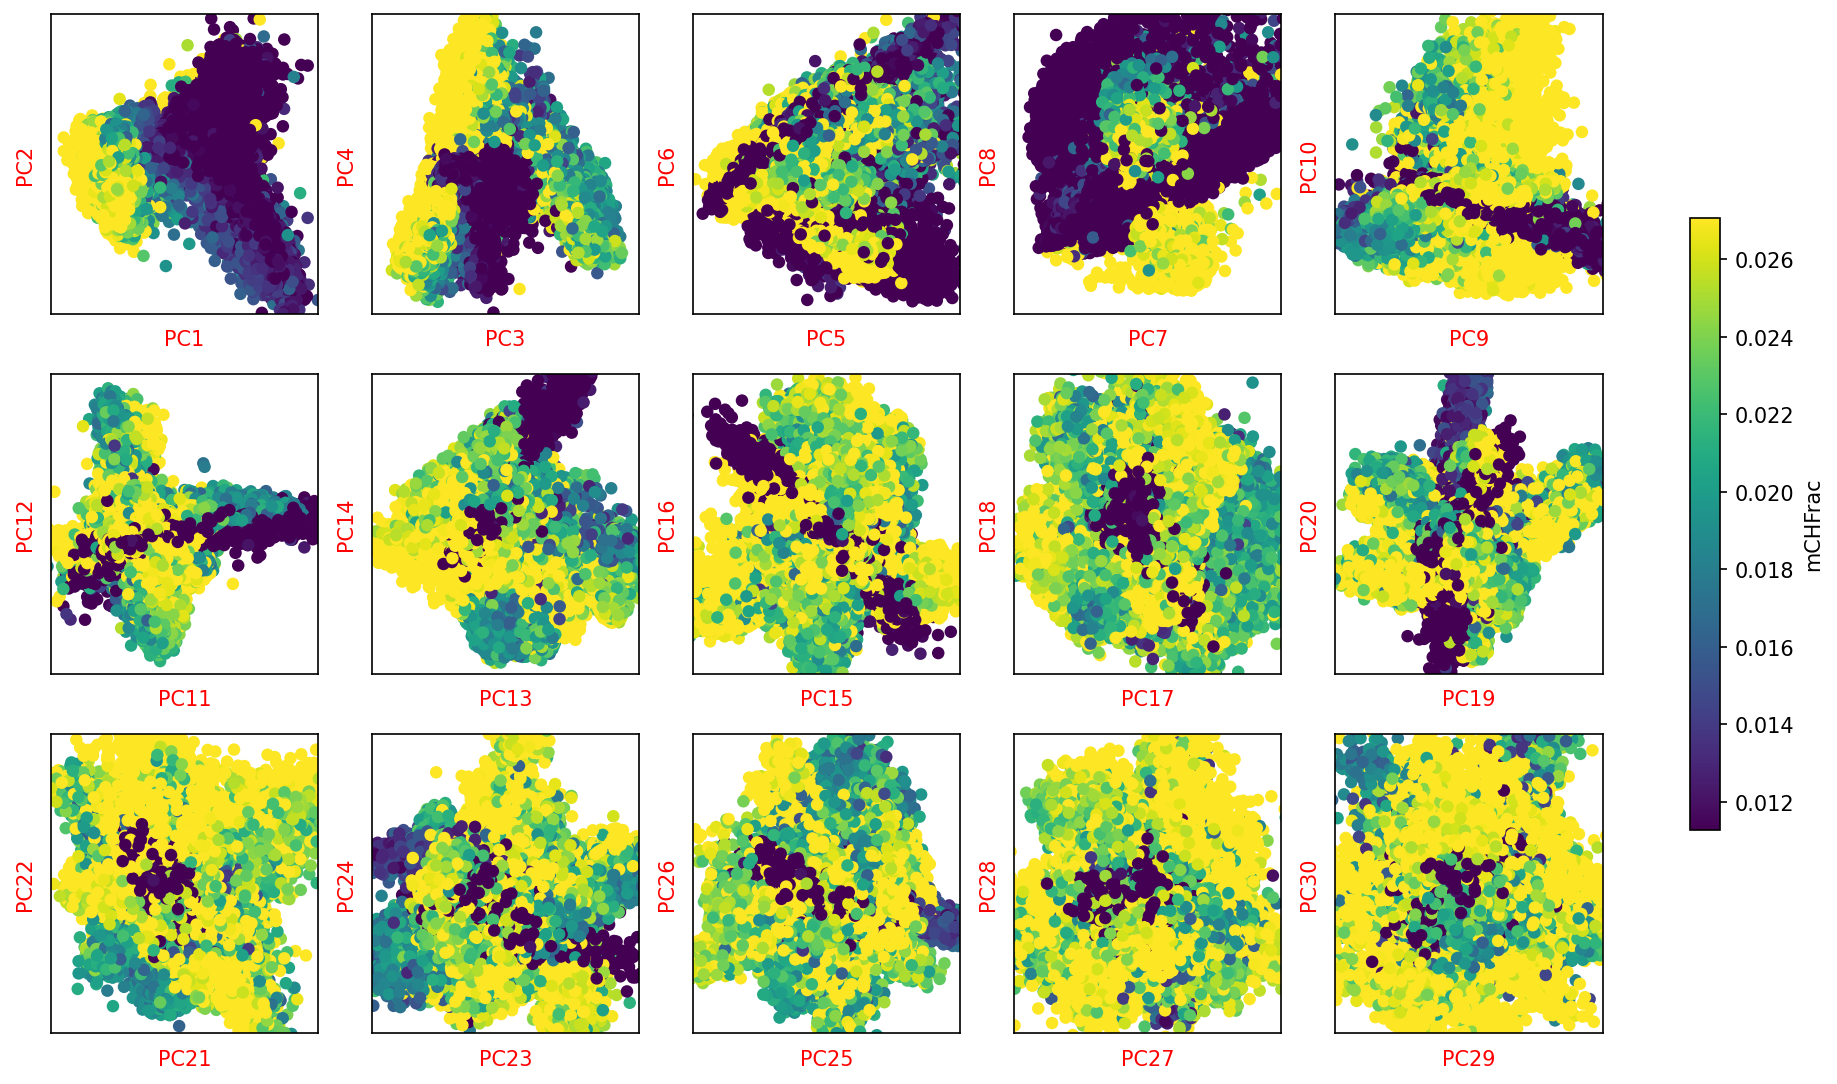

In [18]:
sc.tl.pca(mch_adata)
ch_n_components = significant_pc_test(mch_adata)
fig, axes = plot_decomp_scatters(mch_adata,
                                 n_components=ch_n_components,
                                 hue=mch_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

In [19]:
tmpdf = pd.DataFrame(mcg_adata.X)
use_cell_id = tmpdf.dropna().index
len(use_cell_id)

72666

In [20]:
mcg_adata = mcg_adata[use_cell_id,:].copy()
mch_adata = mch_adata[use_cell_id,:].copy()

Downsample PC matrix to 50000 cells to calculate significant PC components
49 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (72666, 50) to (72666, 49)
Red axis labels are used PCs


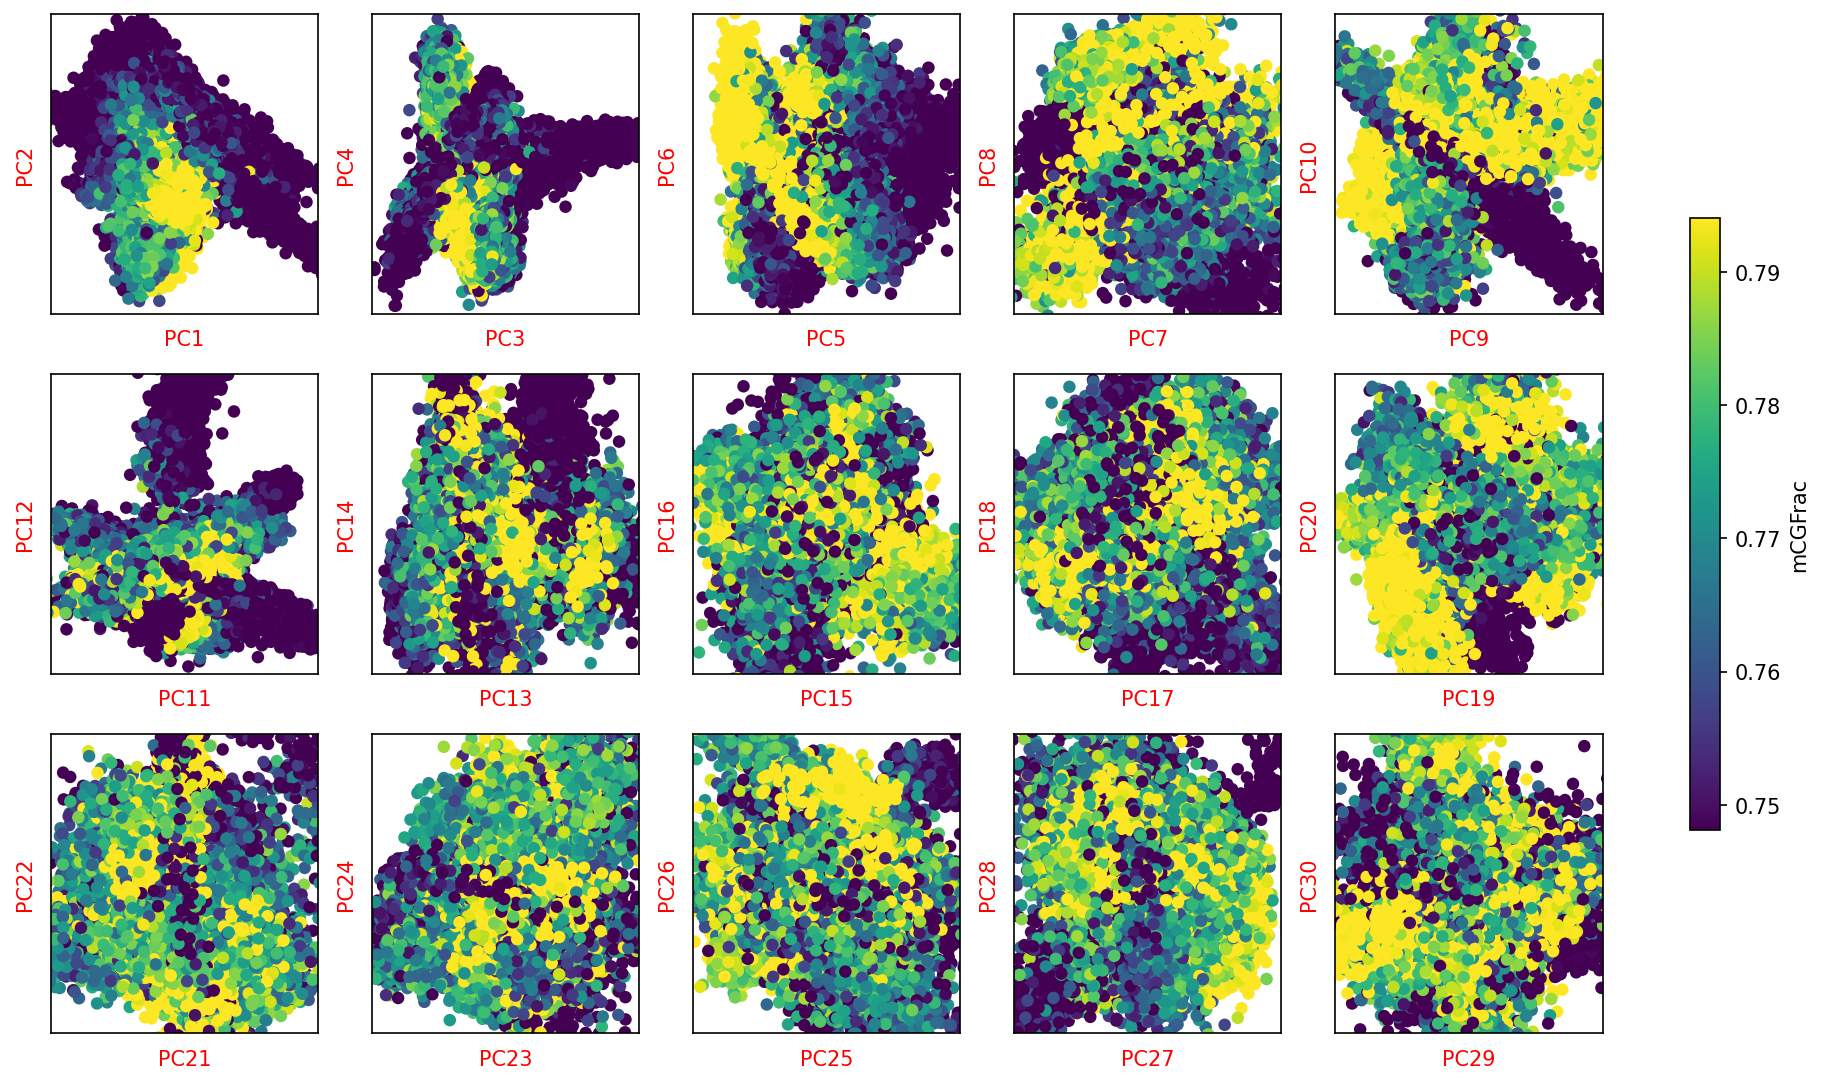

In [21]:
sc.tl.pca(mcg_adata)
cg_n_components = significant_pc_test(mcg_adata)
fig, axes = plot_decomp_scatters(mcg_adata,
                                 n_components=cg_n_components,
                                 hue=mcg_col_name,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=3,
                                 ncols=5)

In [22]:
ch_pcs = mch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = mcg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = mch_adata.copy()
adata.obsm['X_pca'] = total_pcs
del adata.uns['pca']
del adata.varm['PCs']

In [23]:
if knn == -1:
    knn = max(15, int(np.log2(adata.shape[0])*2))
sc.pp.neighbors(adata, n_neighbors=knn)

In [24]:
sc.tl.leiden(adata, resolution=resolution)

In [25]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

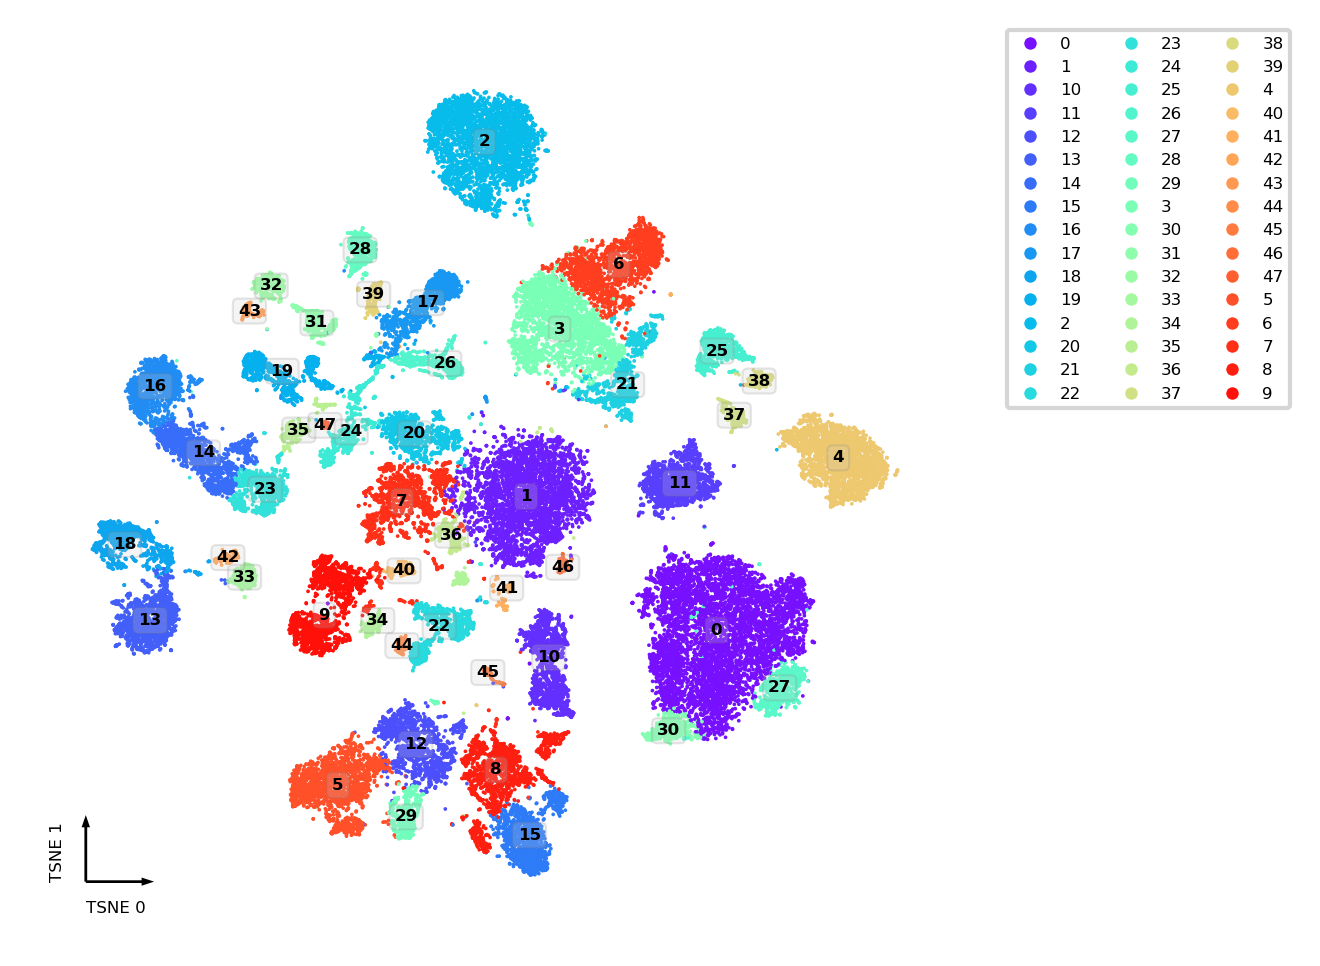

In [26]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata,
                        ax=ax,
                        coord_base='tsne',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

In [27]:
sc.tl.umap(adata)

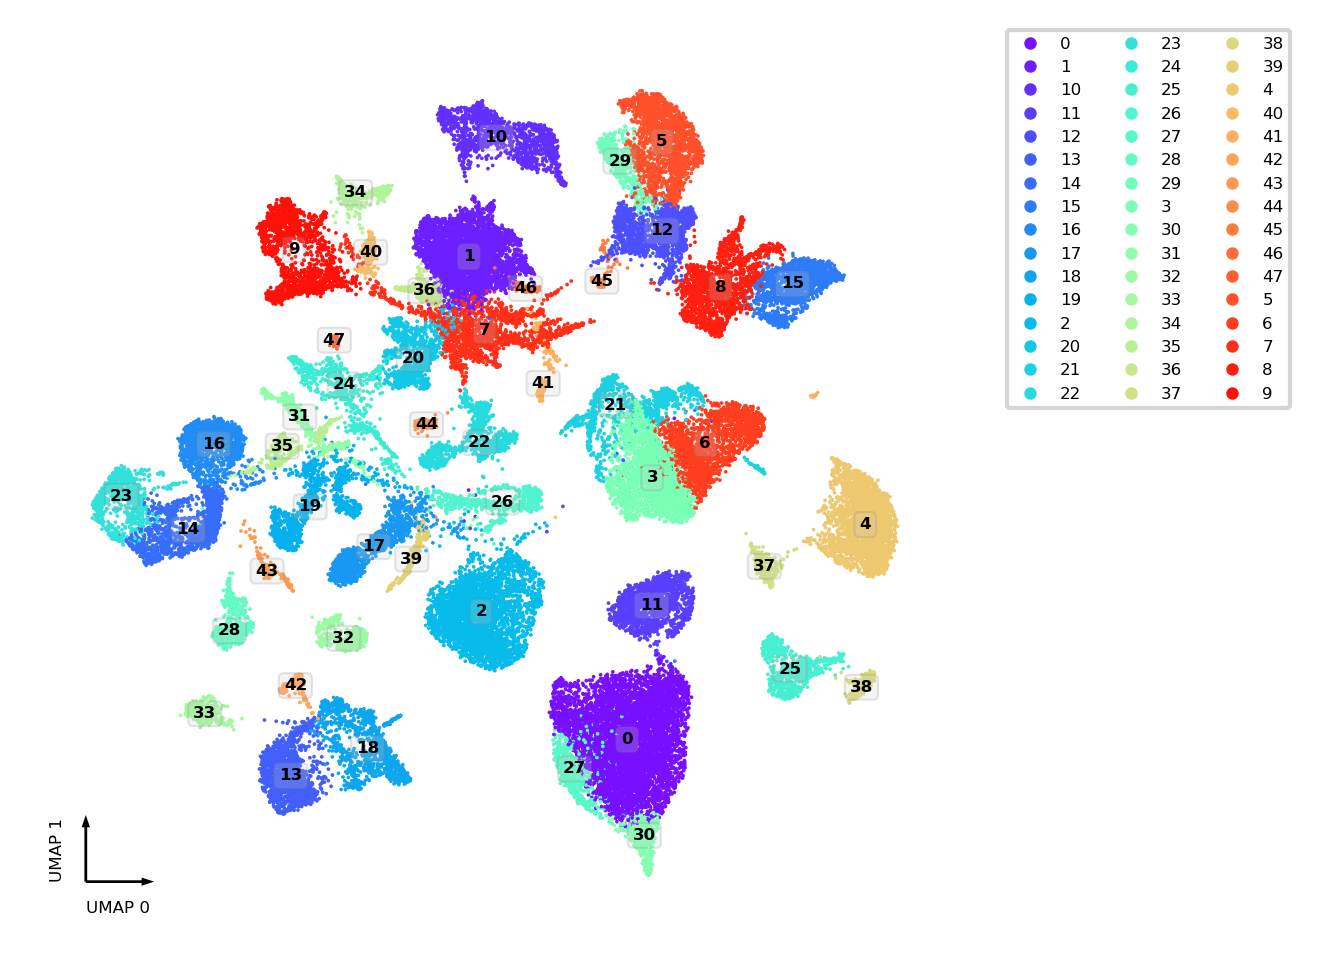

In [28]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
_ = categorical_scatter(data=adata,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        show_legend=True)

In [ ]:
adata.write_h5ad('female.chrom100k-clustering.h5ad')
adata

In [ ]:
adata.obs.to_csv('leiden_meta.csv')